# Clustering and Viz Experimentation

In [2]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 500
max_count_per_class = 200

In [5]:
sk_data, sk_labels, class_count_dict = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count, class_count, max_count_per_class, class_dict, buffer_pix=1)

sk_data.shape, sk_labels.shape, class_count_dict

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
Processing Complete.


((188, 28), (188, 2), {0: 81, 1: 1, 2: 74, 3: 28, 4: 0, 5: 4})

In [5]:
class_dict

{0: 'Water',
 1: 'Developed',
 2: 'Forest',
 3: 'Cultivated',
 4: 'Barren',
 5: 'Wetland'}

## Spectral Signatures

Landsat 5 specs from USGS https://www.usgs.gov/land-resources/nli/landsat/landsat-5

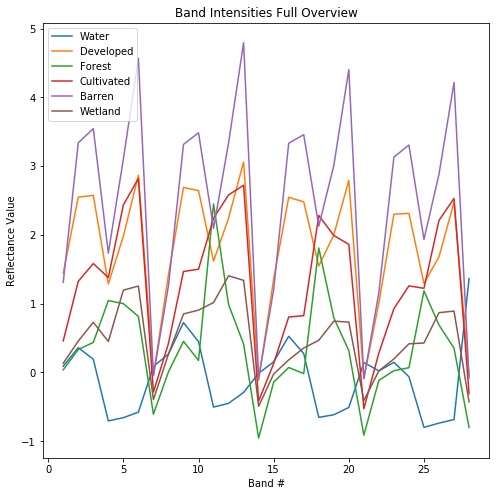

In [6]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,29)

for class_index in class_dict:
    band_intensity = np.mean(sk_data[sk_labels==class_index, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [7]:
sk_data.reshape(-1,4,7).shape

(901, 4, 7)

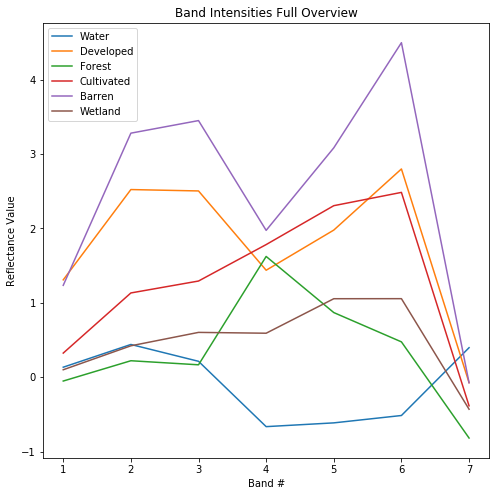

In [8]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,8)

for class_index in class_dict:
    # reshape into 4 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(sk_data[sk_labels==class_index, :].reshape(-1,time_steps,7), axis=(0,1))
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


### Dendrogram

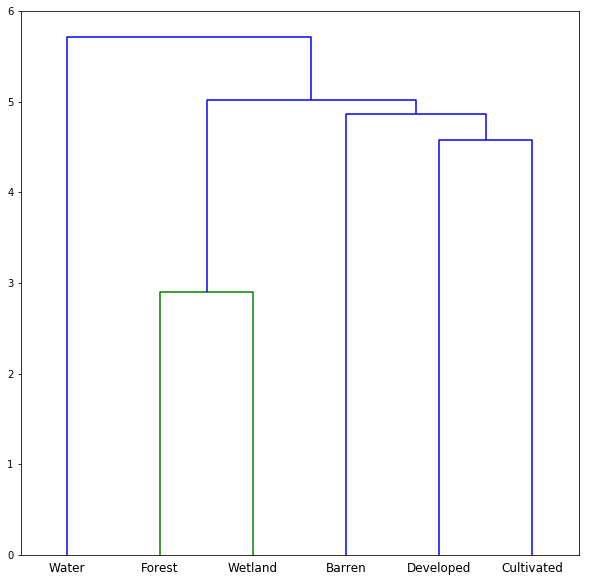

In [9]:
from scipy.cluster import hierarchy

image_avgs = []    
for class_index in class_dict:
    image_avgs.append(np.mean(sk_data[sk_labels==class_index, :], axis=0))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

### PCA and Clustering

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(sk_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : sk_labels})

Explained variation per principal component: [0.60986316 0.15798381 0.07356655]


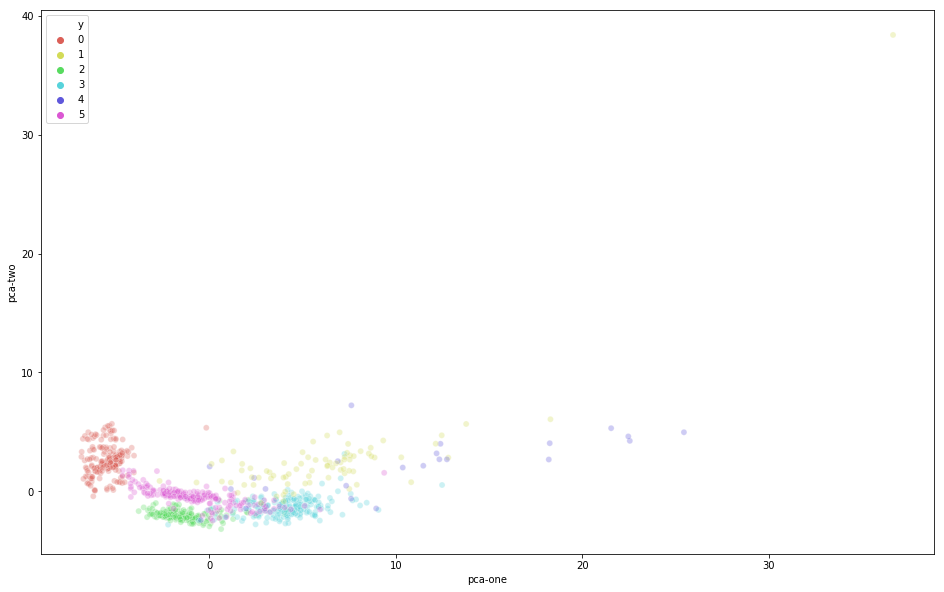

In [11]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df,
    legend="full",
    alpha=0.3
)

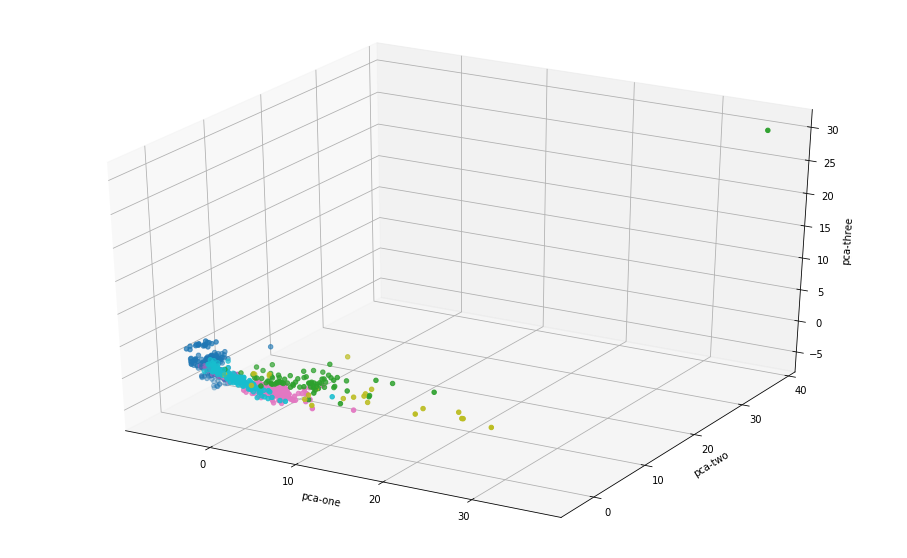

In [12]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [13]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_data[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.001s...
[t-SNE] Computed neighbors for 901 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 1.001957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.736160
[t-SNE] KL divergence after 1000 iterations: 0.467313
t-SNE done! Time elapsed: 5.8433518409729 seconds


In [14]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

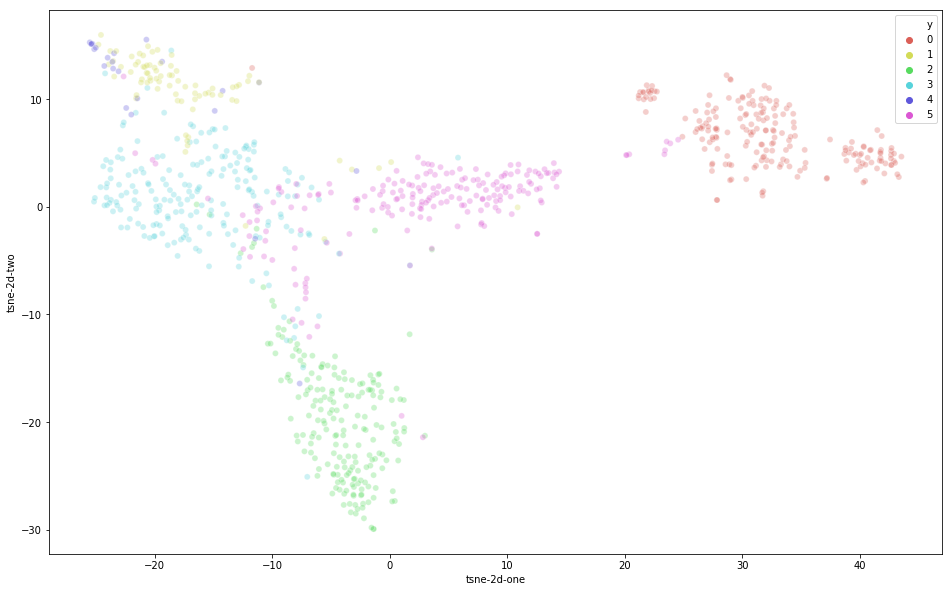

In [15]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df_subset,
    legend="full",
    alpha=0.3
)